## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from utils import text_to_utf8
#from denoiser import Denoiser


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

!nvidia-smi



Wed Mar  4 13:02:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 71%   67C    P2   156W / 250W |  10018MiB / 11019MiB |     78%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 46%   54C    P0    37W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
        

#### Setup hparams

In [5]:
hparams = create_hparams()
hparams.sampling_rate = 22050


#### Load model from checkpoint

In [6]:
checkpoint_path = "outdir/checkpoint_9000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()


In [7]:
!nvidia-smi

Wed Mar  4 13:02:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 71%   68C    P2   237W / 250W |  10018MiB / 11019MiB |     81%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 50%   55C    P2    70W / 250W |   1240MiB / 11019MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [28]:
text = "This paper proposes a neural sequence-to-sequence text-to-speech (TTS) model which can control latent attributes in the generated speech that"
sequence = np.array(text_to_utf8(text))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

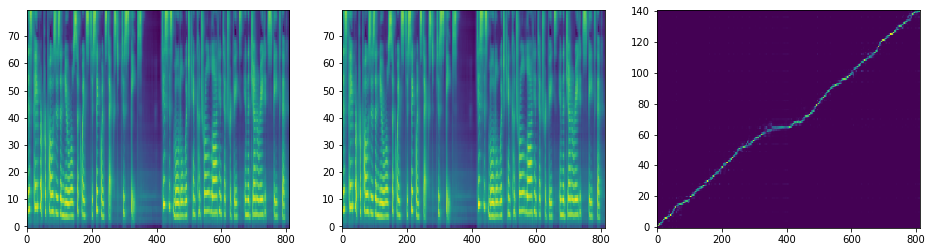

In [29]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))


[[0.         0.01552772 0.02265139 ... 0.         0.         0.        ]
 [0.         0.         0.00420203 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


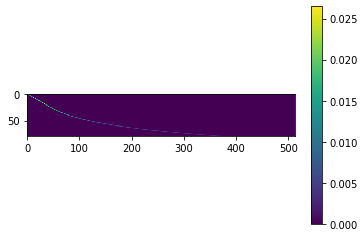

(513, 80)


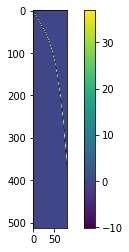

(80, 811)
(513, 811)


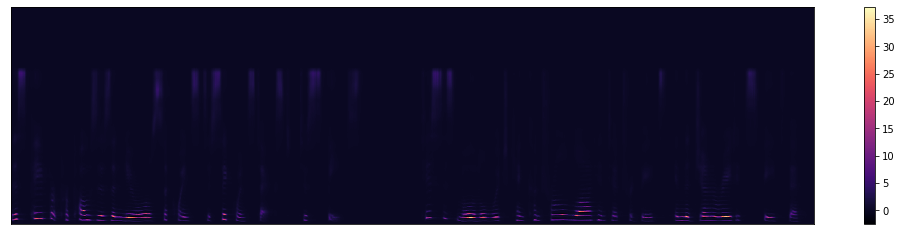

(207360,)


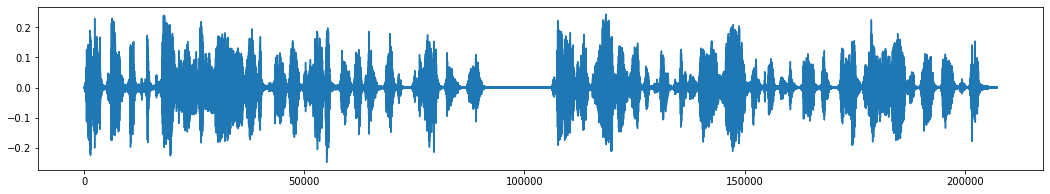

In [30]:
'''
sampling_rate=22050,
filter_length=1024,
hop_length=256,
win_length=1024,
mel_fmin=0.0,
mel_fmax=8000.0,
'''

import librosa
import librosa.display
from librosa.filters import mel as librosa_mel_fn

_mels = mel_outputs_postnet.float().data.cpu().numpy()[0]
mel_basis = librosa_mel_fn(22050, 1024, 80, 0, 8000)

print(mel_basis)

plt.imshow(mel_basis)
plt.colorbar()
plt.show()

mel_inv_basis = np.linalg.pinv(mel_basis)

print(mel_inv_basis.shape)
plt.imshow(mel_inv_basis)
plt.colorbar()
plt.show()

_specs = np.exp(_mels)
print(_specs.shape)
_specs = mel_inv_basis @ _specs
print(_specs.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(_specs)
plt.colorbar()
plt.show()

y = librosa.core.griffinlim(S=_specs, hop_length=256, win_length=1024, window='hann')
print(y.shape)

plt.figure(figsize=[18, 3])
plt.plot(y)
plt.show()

import IPython.display as ipd
ipd.Audio(y, rate=22050) 